## Custom Model and Dataset Example

This example demonstrates how to create GNNShap explanations for a custom model and dataset.

**__Please make sure to run this notebook from the project's root directory.__**

## Model and Training

In [1]:
# Source: https://raw.githubusercontent.com/pyg-team/pytorch_geometric/master/examples/gcn.py

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.logging import init_wandb, log
from torch_geometric.nn import GCNConv
import tqdm


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

dataset = Planetoid(name='Cora', root='./data/Planetoid', transform=T.NormalizeFeatures())
data = dataset[0].to(device)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x


model = GCN(
    in_channels=dataset.num_features,
    hidden_channels=16,
    out_channels=dataset.num_classes,
).to(device)

optimizer = torch.optim.Adam([
    dict(params=model.conv1.parameters(), weight_decay=5e-4),
    dict(params=model.conv2.parameters(), weight_decay=0)], lr=0.01)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_attr).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
pbar = tqdm.tqdm(range(1, 201))
for epoch in pbar:
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    #log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
    pbar.set_postfix({'Loss': loss, 'Test': test_acc, 'Val': val_acc})

100%|██████████| 200/200 [00:01<00:00, 105.75it/s, Loss=0.425, Test=0.805, Val=0.788]


## Explanation

In [2]:
from gnnshap.explainer import GNNShapExplainer

explain_node_idx = 0
gshap = GNNShapExplainer(model, data, nhops=2, verbose=0, device=device,
                    progress_hide=True)

explanation = gshap.explain(explain_node_idx, nsamples=10000,
                            sampler_name='GNNShapSampler', batch_size=1024)

In [3]:
explanation.shap_values

array([-2.1486670e-04, -2.3816838e-03,  1.4363828e-02,  2.5278145e-02,
        2.1766184e-03, -5.6204607e-04, -1.0801930e-02, -9.5426207e-03,
        2.0234374e-02,  5.5574486e-03, -1.6677902e-06, -5.1246475e-02,
       -1.0318816e-02], dtype=float32)

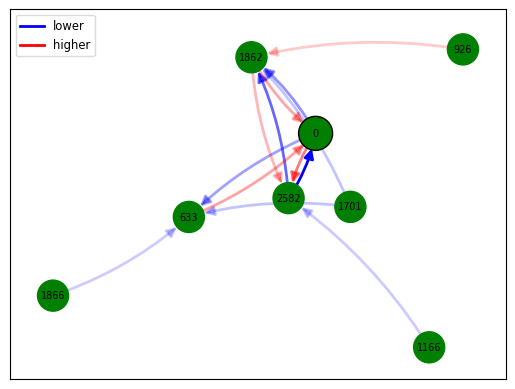

In [4]:
explanation.plot_graph()